In [1]:
using StatisticalRethinking
gr(size=(500,500));

Turing.setadbackend(:reverse_diff)

ProjDir = rel_path("..", "chapters", "04")
cd(ProjDir)

loaded


┌ Warning: Package Turing does not have CmdStan in its dependencies:
│ - If you have Turing checked out for development and have
│   added CmdStan as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Turing
│ Loading CmdStan into Turing from project dependency, future warnings for Turing are suppressed.
└ @ nothing nothing:840


### snippet 4.43

In [2]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [3]:
df2 = filter(row -> row[:age] >= 18, df);

Center the weight observations and add a column to df2

In [4]:
mean_weight = mean(df2[:weight])
df2 = hcat(df2, df2[:weight] .- mean_weight)
rename!(df2, :x1 => :weight_c); # Rename our col :x1 => :weight_c

Extract variables for Turing model

In [5]:
y = convert(Vector{Float64}, df2[:height]);
x = convert(Vector{Float64}, df2[:weight_c]);

Define the regression model

In [6]:
@model line(y, x) = begin
    #priors
    alpha ~ Normal(178.0, 100.0)
    beta ~ Normal(0.0, 10.0)
    s ~ Uniform(0, 50)

    #model
    mu = alpha .+ beta*x
    for i in 1:length(y)
      y[i] ~ Normal(mu[i], s)
    end
end;

Disable updating progress of sampling process

In [7]:
Turing.turnprogress(false);

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /Users/rob/.julia/packages/Turing/xp88X/src/Turing.jl:81


Draw the samples

In [8]:
chn = sample(line(y, x), Turing.NUTS(2000, 200, 0.65));

┌ Info: [Turing] looking for good initial eps...
└ @ Turing /Users/rob/.julia/packages/Turing/xp88X/src/samplers/support/hmc_core.jl:246
[NUTS{Turing.FluxTrackerAD,Union{}}] found initial ϵ: 9.765625e-5
└ @ Turing /Users/rob/.julia/packages/Turing/xp88X/src/samplers/support/hmc_core.jl:291
┌ Warning: Numerical error has been found in gradients.
└ @ Turing /Users/rob/.julia/packages/Turing/xp88X/src/core/ad.jl:154
┌ Warning: grad = [2.87442, 1.13369, NaN]
└ @ Turing /Users/rob/.julia/packages/Turing/xp88X/src/core/ad.jl:155
┌ Info:  Adapted ϵ = 0.048916981924135294, std = [1.0, 1.0, 1.0]; 200 iterations is used for adaption.
└ @ Turing /Users/rob/.julia/packages/Turing/xp88X/src/samplers/adapt/adapt.jl:91


[NUTS] Finished with
  Running time        = 174.35367367200018;
  #lf / sample        = 0.006;
  #evals / sample     = 19.585;
  pre-cond. metric    = [1.0, 1.0, 1.0].


Describe the chain result

In [9]:
describe(chn)

Iterations = 1:2000
Thinning interval = 1
Chains = 1
Samples per chain = 2000

Empirical Posterior Estimates:
               Mean            SD        Naive SE        MCSE         ESS    
   alpha   152.667760577  12.963295233 0.2898680935  1.9064933504   46.233869
    beta     0.904140240   0.091618423 0.0020486502  0.0008881590 2000.000000
  lf_num     0.006000000   0.268328157 0.0060000000  0.0060000000 2000.000000
       s     6.266665195   6.434094411 0.1438707248  1.1551333108   31.024918
 elapsed     0.087176837   0.142891027 0.0031951405  0.0045800175  973.364803
 epsilon     0.060923488   0.116768977 0.0026110337  0.0112827671  107.108442
      lp -1119.947049834 234.300329374 5.2391146363 36.2487389691   41.779188
eval_num    19.585000000  16.885388156 0.3775687574  0.5493208726  944.865288
  lf_eps     0.060923488   0.116768977 0.0026110337  0.0112827671  107.108442

Quantiles:
               2.5%           25.0%           50.0%           75.0%          97.5%    
   alpha   

Show corrected results (Drop adaptation samples)

In [10]:
for var in [:alpha, :beta, :s]
  println("$var = ",  mean_and_std(chn[Symbol(var)][1001:2000]))
end

alpha = (154.58624745072464, 0.24607428105054843)
beta = (0.905527917573359, 0.045451543586106924)
s = (5.115155765550671, 0.20754394076364754)


Compare with a previous result

In [11]:
clip_43s_example_output = "

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
         Mean        SD       Naive SE       MCSE      ESS
alpha 154.597086 0.27326431 0.0043206882 0.0036304132 1000
 beta   0.906380 0.04143488 0.0006551430 0.0006994720 1000
sigma   5.106643 0.19345409 0.0030587777 0.0032035103 1000

Quantiles:
          2.5%       25.0%       50.0%       75.0%       97.5%
alpha 154.0610000 154.4150000 154.5980000 154.7812500 155.1260000
 beta   0.8255494   0.8790695   0.9057435   0.9336445   0.9882981
sigma   4.7524368   4.9683400   5.0994450   5.2353100   5.5090128
";

Example result for Turing with centered weights (appears biased)

In [12]:
clip_43t_example_output = "

[NUTS] Finished with
  Running time        = 163.20725027799972;
  #lf / sample        = 0.006;
  #evals / sample     = 19.824;
  pre-cond. metric    = [1.0, 1.0, 1.0].

                       Mean                              SD
alpha = (154.6020248402468, 0.24090814737592972)
beta   = (0.9040183717679473, 0.0422796486734481)
s        = (5.095714121087817, 0.18455074897377258)

";

Plot the regerssion line and observations

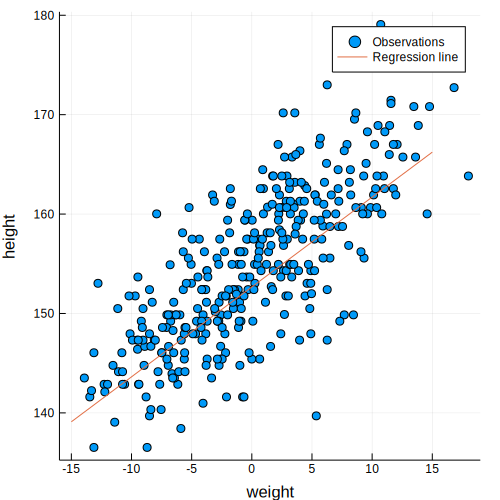

In [13]:
xi = -15.0:0.1:15.0
yi = mean(chn[:alpha]) .+ mean(chn[:beta])*xi

scatter(x, y, lab="Observations", xlab="weight", ylab="height")
plot!(xi, yi, lab="Regression line")

End of `clip_43t.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*